In [1]:
import argparse
from get_data import main
from cnn.training import get_trained_model

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', help='Path to the config file', default='./default_config.yml')
parser.add_argument('--log-dir', help='Path to the log directory', default='../log/')
parser.add_argument('--posters', help='Path to the posters', default='../data/posters/')
parser.add_argument('--models-dir', help='Path to the saved models', default='../data/models/')
parser.add_argument('--sets-dir', help='Path to the training and testing sets', default='../data/sets/')
parser.add_argument('--database', help='Path to the databse csv', default='../data/poster_data.csv')
parser.add_argument('--csv', help='Path to the clean csv', default='../data/')
parser.add_argument('-s', '--save', help='Save model', action='store_true')
parser.add_argument('-v', '--verbose', help='Verbose', action='store_true')

str_args = '-v -s --config ./transfer_learning.yml'.split()
args, _ = parser.parse_known_args(str_args)

In [3]:
clean_movies, train_posters, train_genres, train_ids, test_posters, test_genres, test_ids, model_name, save_model, verbose = main(args)
clean_movies.set_index('allocine_id', inplace=True)

  6%|▌         | 706/11935 [00:00<00:01, 7055.57it/s]

Database already cleaned
Posters database downloading


 91%|█████████ | 10837/11935 [00:03<00:00, 1624.41it/s]

Error HTTP Error 404: Not Found with film 9532


100%|██████████| 11935/11935 [00:03<00:00, 3379.31it/s]


Database downloaded
Training and testing sets already made


In [4]:
custom_resnet, training_history = get_trained_model(model_name, train_posters, train_genres)

Model already trained
No training history


In [5]:
predicted_genres = custom_resnet.predict(test_posters)

In [6]:
from utils.display.training_display import plot_loss, plot_accuracy
from utils.accuracy import mono_label
%matplotlib inline

print(mono_label(test_genres, predicted_genres))
if training_history is not None:
    plot_loss(training_history)
    plot_accuracy(training_history)

0.2


In [7]:
import yaml
config = yaml.safe_load(open(args.config))
genres_inv = {config['genres'][k]: k for k in config['genres'].keys()}
print(genres_inv)

{0: 'Action', 1: 'Animation', 2: 'Comédie', 3: 'Comédie dramatique', 4: 'Documentaire', 5: 'Drame', 6: 'Thriller-Policier'}


In [14]:
import numpy as np

# FOR MULTI LABEL
# predictions = [] 
# for pred in predicted_genres:
#     first3_index = np.argsort(pred)[-3:]
#     predictions.append([genres_inv[k] for k in first3_index])
# ground_truth = []
# for truth in test_genres:
#     first3_index = np.nonzero(truth)[0]
#     ground_truth.append([genres_inv[k] for k in first3_index])

predictions = np.array([genres_inv[k] for k in np.argmax(predicted_genres, axis=1)])
ground_truth = np.array([genres_inv[k] for k in np.argmax(test_genres, axis=1)])

In [9]:
r = np.random.permutation(100)[:10]
for i in r:
    print('{}: truth: {}, pred: {}'.format(clean_movies.loc[test_ids[i], 'title'], ground_truth[i], predictions[i]))
#     print('Ground truth: {}, real: {}'.format(ground_truth[i], movies.loc[test_ids[i], 'genres']))

L’Enfer blanc du Piz Palü: truth: Drame, pred: Documentaire
Mourir comme un homme: truth: Drame, pred: Thriller-Policier
M: truth: Documentaire, pred: Documentaire
Ma vie n'est pas une comédie romantique: truth: Comédie, pred: Documentaire
Le Garçon et la Bête: truth: Animation, pred: Documentaire
Kingsman 3: truth: Action, pred: Documentaire
Entre deux rives: truth: Drame, pred: Action
L'Âge de glace : La dérive des continents: truth: Animation, pred: Animation
Zaytoun: truth: Drame, pred: Comédie
Free Guy: truth: Comédie, pred: Documentaire


In [10]:
genres = genres_inv.values()

results_per_genre = {
    genre_true : {genre_pred : 0 for genre_pred in genres}
    for genre_true in genres
}

total_per_genre = {
    genre : 0
    for genre in genres
}

n = len(predictions)
for i in range(n):
    results_per_genre[ground_truth[i]][predictions[i]] += 1
    total_per_genre[ground_truth[i]] += 1

for genre_true in genres:
    print(
        genre_true + " (" + str(total_per_genre[genre_true] / n) + "):"
    )
    for genre_pred in genres:
        print(
            "    " + genre_pred + ": " + str(
                results_per_genre[genre_true][genre_pred] / total_per_genre[genre_true]
            )
        )
    print()

Action (0.14285714285714285):
    Action: 0.047619047619047616
    Animation: 0.09523809523809523
    Comédie: 0.08571428571428572
    Comédie dramatique: 0.2
    Documentaire: 0.4
    Drame: 0.10476190476190476
    Thriller-Policier: 0.06666666666666667

Animation (0.14285714285714285):
    Action: 0.0
    Animation: 0.4380952380952381
    Comédie: 0.08571428571428572
    Comédie dramatique: 0.05714285714285714
    Documentaire: 0.37142857142857144
    Drame: 0.02857142857142857
    Thriller-Policier: 0.01904761904761905

Comédie (0.14285714285714285):
    Action: 0.01904761904761905
    Animation: 0.1619047619047619
    Comédie: 0.20952380952380953
    Comédie dramatique: 0.047619047619047616
    Documentaire: 0.4857142857142857
    Drame: 0.0380952380952381
    Thriller-Policier: 0.0380952380952381

Comédie dramatique (0.14285714285714285):
    Action: 0.01904761904761905
    Animation: 0.14285714285714285
    Comédie: 0.17142857142857143
    Comédie dramatique: 0.0761904761904762
 

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

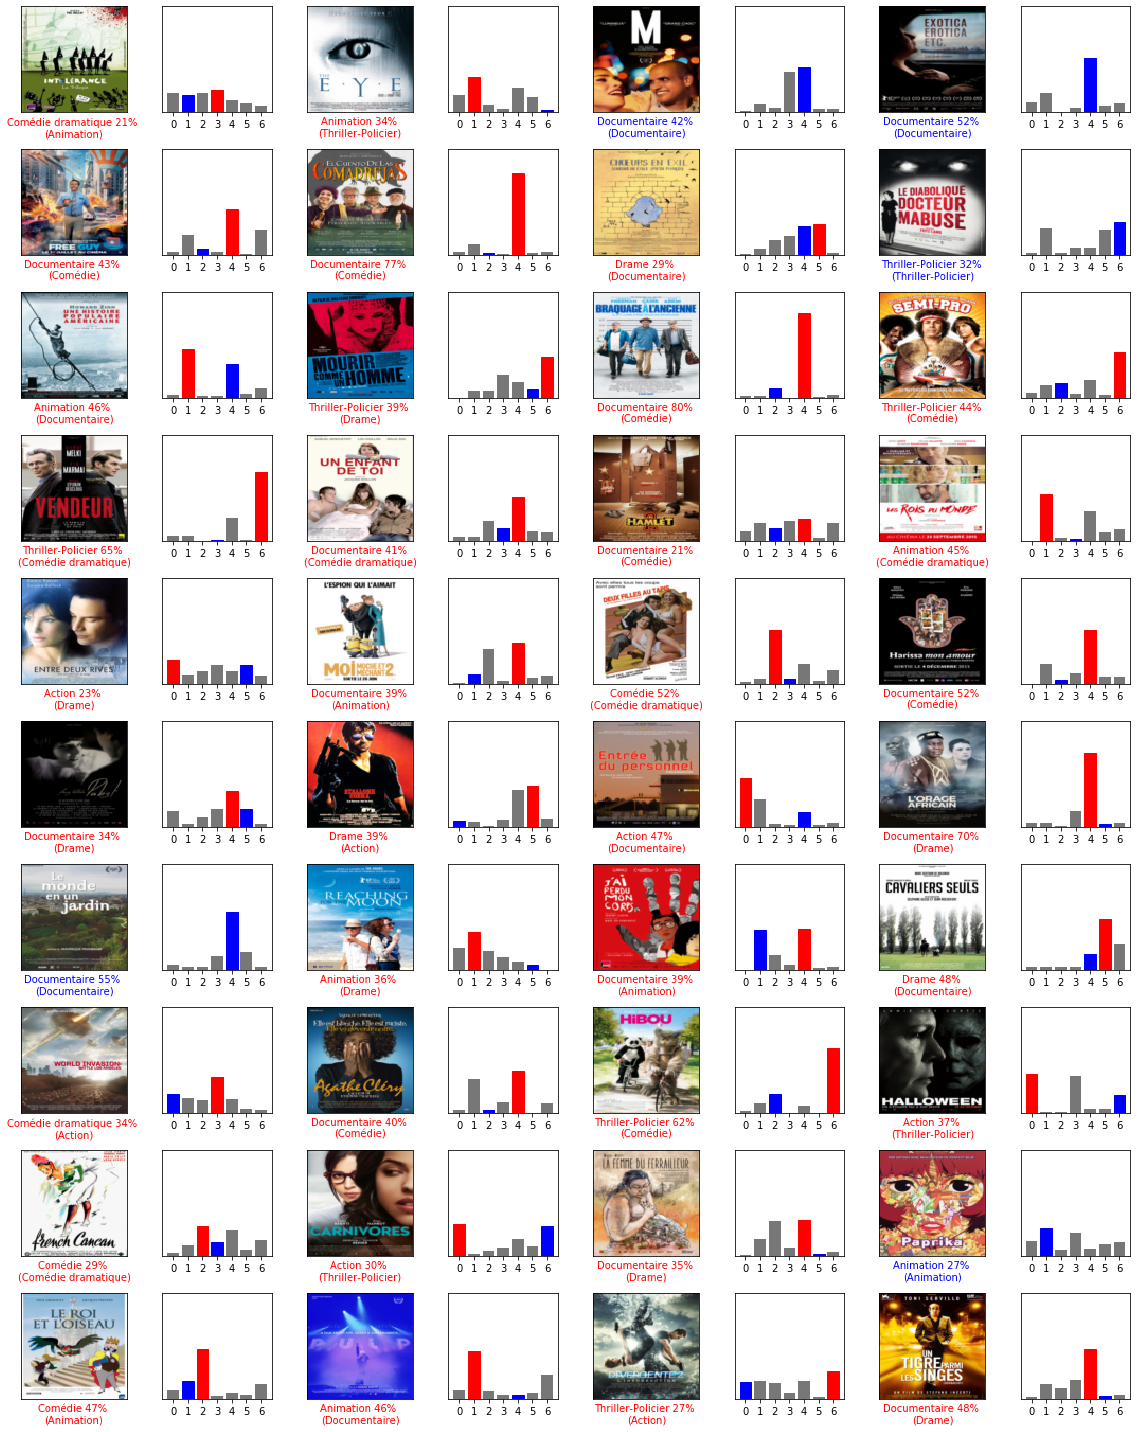

In [13]:
from utils.display.results_display import plot_test_results

starting_index = 10
num_row, num_cols = 10, 4
plot_test_results(test_posters, test_genres, genres_inv, predicted_genres, starting_index, num_row, num_cols)